## Códigos donde se implementan los baselines
--- 
pasarlos a .py después

https://lingpipe-blog.com/category/data-annotation/

Segun Rodrigues 2018:
* batch= 16, 64 o 128
* iterations= 20, 30, 50 o 100
* adam
* Pe entrena con MV por 5 epochs: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

### load Data

In [3]:


#from sklearn.datasets import load_svmlight_files
#X_train, y_train, X_test, y_test = load_svmlight_files(("../toy_data/a9a.txt","../toy_data/a9a.txt"))

"""
df_red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",sep=';')

df_red["normal"] = df_red["quality"]==5
df_red["good"] = df_red["quality"]>5
df_red["bad"] = df_red["quality"]<5
df_red["qualities"] = 0*df_red["bad"]+df_red["normal"]+2*df_red["good"]
df_red.drop(['quality','normal','good','bad'],axis=1,inplace=True)

y_train = df_red.pop("qualities").values*1
X_train = df_red.values

y_obs = np.loadtxt("annotations_wine.csv",delimiter=',',dtype='int')
"""

from keras.datasets import cifar10
(X_train, Z_train), (X_test, Z_test) = cifar10.load_data()
#y_obs = np.loadtxt("../syntetic/annotations_cifar.csv",delimiter=',',dtype='int')
y_obs = np.loadtxt("./annotations_cifar_normal.csv",delimiter=',',dtype='int')

""" Syntetic data
X_train = np.loadtxt("../syntetic/datanoisy_X.csv",delimiter=',')
Z_train = np.loadtxt("../syntetic/datanoisy_Z.csv",dtype='int') #groudn truth
y_obs = np.loadtxt("../syntetic/annotations_noisydata.csv",delimiter=',',dtype='int')
"""

"""
X_train = np.loadtxt("../syntetic/datanoisy_X.csv",delimiter=',')
Z_train = np.loadtxt("../syntetic/datanoisy_Z.csv",dtype='int') #groudn truth
y_obs = np.loadtxt("../syntetic/annotations_noisydata.csv",delimiter=',',dtype='int')

"""

#X_test = np.loadtxt("../syntetic/data_X.csv",delimiter=',')
#Z_test = np.loadtxt("../syntetic/data_Z.csv",dtype='int') #groudn truth

groups_annot = np.loadtxt("../syntetic/annotgroups_cifar.csv",delimiter=',',dtype='int')
load_matrix = np.loadtxt('../syntetic/matrix_cifar.csv',delimiter=',')
rows,Kl = load_matrix.shape
real_conf_matrix = np.asarray([load_matrix[j-Kl:j] for j in np.arange(Kl,rows+1,Kl)])
confe_matrix = real_conf_matrix[groups_annot]

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("Shape labels: ",(N,T))
print("Classes: ",K)

Shape labels:  (50000, 100)
Classes:  10


In [4]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 1e-2 #tolerance for relative variation of parameters
TOL_LOSS = 3e-3 #tolerance for relative variation of log-likelihood ---REVISAR

In [18]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2700, 2)

In [5]:
Xstd_train = X_train.astype(DTYPE_OP)/255
Xstd_test = X_test.astype(DTYPE_OP)/255
Z_train = Z_train[:,0]
Z_test = Z_test[:,0]
Xstd_train.shape

(50000, 32, 32, 3)

In [6]:
### Ahora existe una funcion que cambia las representaciones
from representation import *
from utils import *

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
annotations = set_representation(y_obs,'dawid') #for D&S

y_obs_categorical.shape

(50000, 100, 10)

### Model Over Ground Truth
---
un archivo por dataset a probar...

In [39]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)
#model1 = LogisticRegression_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1])
model1 = clone_model(raykarMC.base_model)
model1.compile(loss='categorical_crossentropy',optimizer=OPT)
model1.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
report_results(model1.predict_classes(Xstd_test),Z_test)

Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.9955,0.9954435392756661,0.9955000000000002


In [14]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)
model1 = clone_model(raykarMC.base_model)
model1.compile(loss='categorical_crossentropy',optimizer=OPT)
model1.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1)
report_results(model1.predict_classes(Xstd_test),Z_test) #cifar

Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.7584,0.7571931212275452,0.7584000000000001


In [13]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)
model1 = clone_model(raykarMC.base_model)
model1.compile(loss='categorical_crossentropy',optimizer=OPT)
model1.fit(Xstd_train,Z_train_onehot,epochs=15,batch_size=BATCH_SIZE,verbose=0)

#Import it:
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(model1,'keras',Xstd_train.shape[0])

print("Train")
Z_train_pred = model1.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,y_o=y_obs)

print("Test")
Z_test_pred = model1.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

Train
A result
 +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |    0.97028 |            0.97028 |
+----+--------+------------+--------------------+
Test
A result
 +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |     0.8043 |             0.8043 |
+----+--------+------------+--------------------+


In [29]:
from utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL) #relative delta

ImportError: cannot import name 'EarlyStopRelative'

In [11]:
TOL

0.01

In [15]:
#modelo mas regularizado?
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T)
#raykarMC.define_model("default cnn")
#raykarMC.define_model("simple cnn",32,2,drop=0.25,double=True,BatchN=True)
raykarMC.define_model('mlp',16,1,drop=0.2,BatchN=False)
#logL_hist = raykarMC.stable_train(Xstd_train,y_obs_categorical)

Needed params (units,deep,drop,BatchN?)


In [27]:
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)#0.05 #relative delta

Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)
model1 = clone_model(raykarMC.base_model)
model1.compile(loss='categorical_crossentropy',optimizer=OPT)
model1.fit(Xstd_train,Z_train_onehot,epochs=100,batch_size=BATCH_SIZE,verbose=1,callbacks=[ourCallback])

#Import it:
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(model1,'keras',Xstd_train.shape[0])

print("Train")
Z_train_pred = model1.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,y_o=y_obs)

print("Test")
Z_test_pred = model1.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

Epoch 1/100
2700/2700 [==============================] - 1s 230us/step - loss: 1.2407
Epoch 2/100
2700/2700 [==============================] - 0s 45us/step - loss: 1.1259
Epoch 3/100
2700/2700 [==============================] - 0s 40us/step - loss: 1.0298
Epoch 4/100
2700/2700 [==============================] - 0s 42us/step - loss: 0.9508
Epoch 5/100
2700/2700 [==============================] - 0s 42us/step - loss: 0.8824
Epoch 6/100
2700/2700 [==============================] - 0s 40us/step - loss: 0.8077
Epoch 7/100
2700/2700 [==============================] - 0s 39us/step - loss: 0.7310
Epoch 8/100
2700/2700 [==============================] - 0s 36us/step - loss: 0.6754
Epoch 9/100
2700/2700 [==============================] - 0s 46us/step - loss: 0.6217
Epoch 10/100
2700/2700 [==============================] - 0s 41us/step - loss: 0.5713
Epoch 11/100
2700/2700 [==============================] - 0s 41us/step - loss: 0.5211
Epoch 12/100
2700/2700 [==============================] - 0s 4

### 0. Label inference: Majority Voting - Dawid and Skene
---
* https://github.com/fmpr/LogReg-Crowds ( tiene raykar tambien y rodrigues)

In [7]:
label_I = LabelInference(y_obs,TOL)
label_I.train()

label_I.mv_probas

In [7]:
from baseline import LabelInference

#label_I = LabelInference(y_obs,TOL,type_inf = 'mv')

label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'mv')

#label_I.mv_labels('classes')
mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

#ds_labels = label_I.DS_labels()

In [27]:
print("Accuracy of MV on train: ",np.mean(np.argmax(mv_onehot,axis=1) == Z_train))
print("Accuracy of D&S on train: ",np.mean(np.argmax(ds_labels,axis=1) == Z_train))

Accuracy of MV on train:  0.747037037037037
Accuracy of D6S on train:  1.0


In [55]:
print("CIFAR") #indica que es necesario cambiar las matrices de conf..
print("Accuracy of MV on train: ",np.mean(np.argmax(mv_onehot,axis=1) == Z_train))
print("Accuracy of D&S on train: ",np.mean(np.argmax(ds_labels,axis=1) == Z_train))

CIFAR
Accuracy of MV on train:  0.78728
Accuracy of D&S on train:  0.9842


In [15]:
model_mvhard =  clone_model(raykarMC.base_model)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvhard.fit(Xstd_train,mv_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over hard-MV")
report_results(model_mvhard.predict_classes(Xstd_test),Z_test) #CIFAR

Trained model over hard-MV


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.679,0.6427418991535236,0.679


In [16]:
model_mvsoft = clone_model(raykarMC.base_model)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
model_mvsoft.fit(Xstd_train,mv_probas,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over soft-MV")
report_results(model_mvsoft.predict_classes(Xstd_test),Z_test) #cifar

Trained model over soft-MV


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.6211,0.5789427481682428,0.6211


In [26]:
#model_ds = LogisticRegression_Keras(Xstd_train.shape[1:],ds_labels.shape[1])
model_ds = clone_model(raykarMC.base_model)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
model_ds.fit(Xstd_train,ds_labels,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0)
print("Trained model over D&S inference labels")
report_results(model_ds.predict_classes(Xstd_test),Z_test) #lo mismo que entrenar con GT ya que inferida es la misma

Trained model over D&S inference labels


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.9859259259259259,0.9859090438288707,0.9859259259259259


Modelo predictor funciona mejor (en base al desempeño) al entrenar sobre hard-MV, quizás aprende "fuertemente" de los que efectivamente tienen la etiqueta correcta, además que el modelo predictor logra superar el "accuracy" de sus etiquetas solas sobre el conjunto de test. El modelo soft-MV no logra superar el "accuracy" de los anotadores (llega solo a imitarlos).

In [15]:
logL_hist1 =[]
acc_hist1 =[]
for i in range(10):
    model_mvhard = LogisticRegression_Keras(Xstd_train.shape[1:],mv_onehot.shape[1])
    model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["accuracy"])
    l = model_mvhard.fit(Xstd_train,mv_onehot,epochs=50,batch_size=BATCH_SIZE,verbose=0,validation_data=(Xstd_test,Z_test_onehot))
    logL_hist1.append(l.history["loss"])
    acc_hist1.append(l.history["val_loss"])
logL_hist2 =[]
acc_hist2 = []
for i in range(10):
    model_mvhard = LogisticRegression_Keras(Xstd_train.shape[1:],mv_probas.shape[1])
    model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["accuracy"])
    l = model_mvhard.fit(Xstd_train,mv_probas,epochs=50,batch_size=BATCH_SIZE,verbose=0,validation_data=(Xstd_test,Z_test_onehot))
    logL_hist2.append(l.history["loss"])
    acc_hist2.append(l.history["val_loss"])

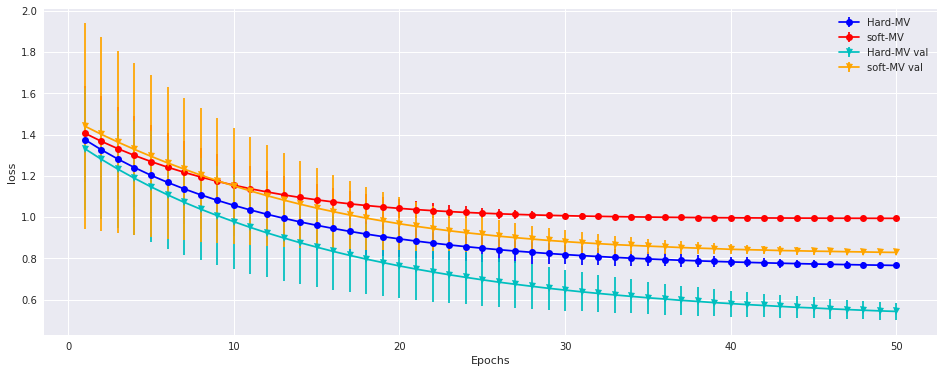

In [16]:
import seaborn as sns
sns.set()
plt.figure(figsize=(16,6))
x = np.arange(1,51)
plt.errorbar(x, np.mean(logL_hist1,axis=0), np.std(logL_hist1,axis=0),marker='o',color='b',label="Hard-MV") #None
plt.errorbar(x, np.mean(logL_hist2,axis=0), np.std(logL_hist2,axis=0),marker='o',color='r',label="soft-MV") #None
plt.errorbar(x, np.mean(acc_hist1,axis=0), np.std(acc_hist1,axis=0),marker='v',color='c',label="Hard-MV val") #None
plt.errorbar(x, np.mean(acc_hist2,axis=0), np.std(acc_hist2,axis=0),marker='v',color='orange',label="soft-MV val") #None
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

### 3. Raykar 2010 and *Deep* (Rodrigues 2018)

In [18]:
from baseline import RaykarMC

In [8]:
%%time
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT)
#raykarMC.define_model("sklearn")
#raykarMC.define_model("keras shallow") #keras pareciera funcionar mejor sin priors
raykarMC.define_model("mlp",16,1) 
#raykarMC.define_model("default cnn")

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato

logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,iterations=10,relative=True,val=True)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2700, 3)
Iter 1/10 
M step: done 	E step: done, (in 2.46 sec)	logL: -42831.383	F1: 0.4130
Iter 2/10 
M step: done 	E step: done, (in 0.21 sec)	logL: -39652.361	Tol: 0.07422	F1: 0.7578
Iter 3/10 
M step: done 	E step: done, (in 0.26 sec)	logL: -39329.683	Tol: 0.00814	F1: 0.8356
Iter 4/10 
M step: done 	E step: done, (in 0.21 sec)	logL: -39231.067	Tol: 0.00251	F1: 0.8593
Iter 5/10 
M step: done 	E step: done, (in 0.19 sec)	logL: -39187.886	Tol: 0.00110	F1: 0.8733
Iter 6/10 
M step: done 	E step: done, (in 0.20 sec)	logL: -39166.951	Tol: 0.00053	F1: 0.8815
Iter 7/10 
M step: done 	E step: done, (in 0.20 sec)	logL: -39150.774	Tol: 0.00041	F1: 0.8852
Iter 8/10 
M step: done 	E step: done, (in 0.21 sec)	logL: -39140.870	Tol: 0.00025	F1: 0.8893
Finished training!
CPU times: user 6.15 s, sys: 707 ms, total: 6.85 s
Wall time: 4.27 s


In [48]:
%%time
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT)
raykarMC.define_model("default cnn")

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,iterations=25,relative=True,val=True)

Initializing new EM...
Betas shape:  (100, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/25 
M step: done 	E step: done, (in 27.09 sec)	logL: -797109.941	F1: 0.4305
Iter 2/25 
M step: done 	E step: done, (in 18.47 sec)	logL: -796261.034	Tol: 0.00106	Tol params conf: 0.45176729647180563F1: 0.6836
Iter 3/25 
M step: done 	E step: done, (in 18.97 sec)	logL: -796252.490	Tol: 0.00001	Tol params conf: 0.06852821761730074F1: 0.7505
Iter 4/25 
M step: done 	E step: done, (in 18.47 sec)	logL: -796200.397	Tol: 0.00007	Tol params conf: 0.01511956223986721F1: 0.7553
Iter 5/25 
M step: done 	E step: done, (in 18.42 sec)	logL: -796140.904	Tol: 0.00007	Tol params conf: 0.004541868316376028F1: 0.8306
Iter 6/25 
M step: done 	E step: done, (in 18.59 sec)	logL: -796144.002	Tol: 0.00000	Tol params conf: 0.0038886677601798624F1: 0.8562
Iter 7/25 
M step: done 	E step: done, (in 19.34 sec)	logL: -796105.355	Tol: 0.00005	Tol params conf: 0.0034023485307075815F1: 0.8702
Iter 8/25 
M step: done 	E step: done,

KeyboardInterrupt: 

In [19]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT)
raykarMC.define_model("default cnn")

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,iterations=25,relative=True,val=True,tolerance=TOL)

Initializing new EM...


NameError: name 'DTYPE_OP' is not defined

In [46]:
#Import it:
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(raykarMC,'raykar')

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,y_o=y_obs)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

Train
A result
 +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |    0.79414 |            0.79414 |
+----+--------+------------+--------------------+
Test
A result
 +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |     0.7449 |             0.7449 |
+----+--------+------------+--------------------+


In [1]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T)
#raykarMC.define_model("sklearn_shallow")
raykarMC.define_model("keras_shallow") #keras pareciera funcionar mejor sin priors
#raykarMC.define_model("mlp",32,2) 

logL_hist = raykarMC.multiples_run(5,Xstd_train,y_obs_categorical)

NameError: name 'RaykarMC' is not defined

In [8]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T)
raykarMC.define_model("default cnn")

logL_hist = raykarMC.multiples_run(10,Xstd_train,y_obs_categorical)

Initializing new EM...
Betas shape:  (100, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done 	E step: done, (in 22.76 sec)	logL: -797109.284	
Iter 2/50 
M step: done 	E step: done, (in 15.96 sec)	logL: -796259.587	Tol: 0.00107	
Iter 3/50 
M step: done 	E step: done, (in 15.89 sec)	logL: -796229.505	Tol: 0.00004	
Finished training!
Initializing new EM...
Betas shape:  (100, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done 	E step: done, (in 21.50 sec)	logL: -797108.265	
Iter 2/50 
M step: done 	E step: done, (in 17.33 sec)	logL: -796264.292	Tol: 0.00106	
Iter 3/50 
M step: done 	E step: done, (in 16.96 sec)	logL: -796203.131	Tol: 0.00008	
Finished training!
Initializing new EM...
Betas shape:  (100, 10, 10)
Q estimate shape:  (50000, 10)
Iter 1/50 
M step: done 	E step: done, (in 22.03 sec)	logL: -797108.421	
Iter 2/50 
M step: done 	E step: done, (in 16.77 sec)	logL: -796265.827	Tol: 0.00106	
Iter 3/50 
M step: done 	E step: done, (in 16.70 sec)	logL: -796181

In [10]:
#Import it:
from evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(raykarMC,'raykar')

print("Train")
Z_train_pred = raykarMC.base_model.predict_classes(Xstd_train)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,y_o=y_obs)

print("Test")
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

Train
A result
 +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |     0.7615 |             0.7615 |
+----+--------+------------+--------------------+
Test
A result
 +----+--------+------------+--------------------+
|    |        |   Accuracy |   F1 score (micro) |
|----+--------+------------+--------------------|
|  0 | Global |     0.7244 |             0.7244 |
+----+--------+------------+--------------------+


In [53]:
print("Raykar run over 25 iterations")
report_results(raykarMC.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Raykar run over 25 iterations


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.9577777777777777,0.9578584548676689,0.9577777777777777


In [61]:
print("Raykar run over 50 iterations")
report_results(raykarMC.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Raykar run over 50 iterations


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.9837037037037037,0.9836885157989325,0.9837037037037037


In [99]:
print("Raykar multiple runs (5 runs with 25 iterations)")
report_results(raykarMC.base_model.predict_classes(Xstd_test),Z_test,conf_pred=[],conf_true=[])

Raykar multiple runs (5 runs with 25 iterations)


Acccuracy,F1 score (micro),F1 score (macro)
float64,float64,float64
0.9862962962962963,0.9862785455258257,0.9862962962962963


In [102]:

load_matrix = np.loadtxt('../syntetic/matrix.csv',delimiter=',')
rows,Kl = load_matrix.shape
confe_matrix = []
for j in np.arange(Kl,load_matrix.shape[0]+1,Kl):
    confe_matrix.append(load_matrix[j-Kl:j])
confe_matrix = np.asarray(confe_matrix)
aux = np.loadtxt('../syntetic/groups_noisydata.csv',dtype='int')
annotators_conf = confe_matrix[aux]
#annotators_conf

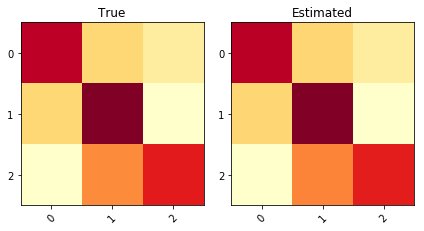

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


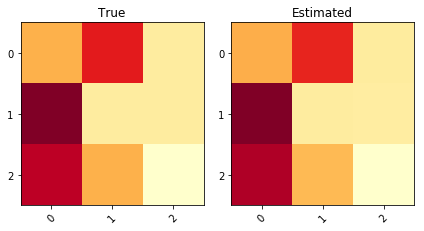

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


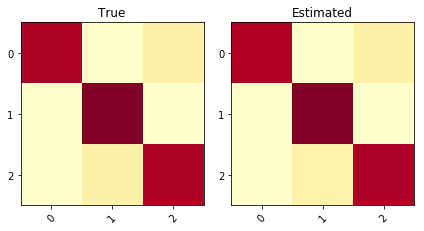

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


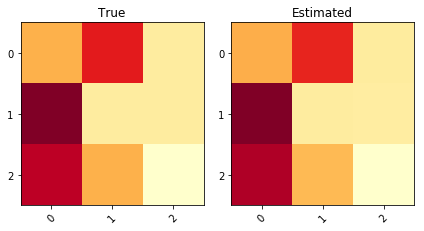

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


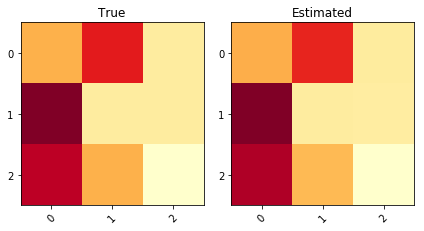

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


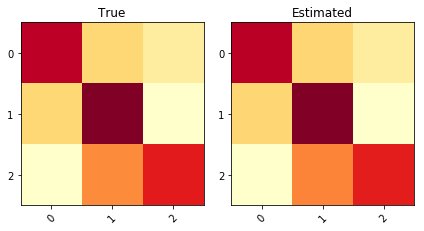

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


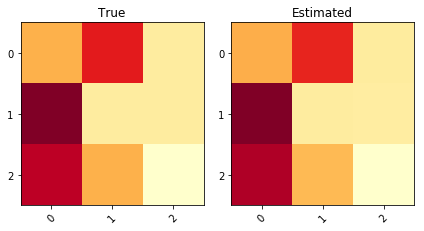

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


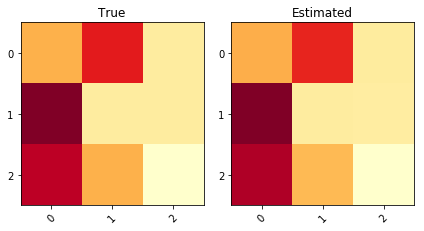

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


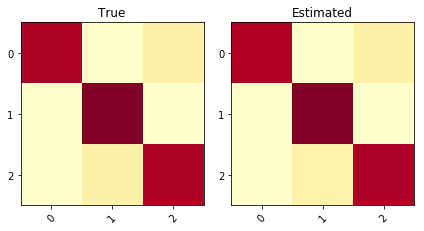

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


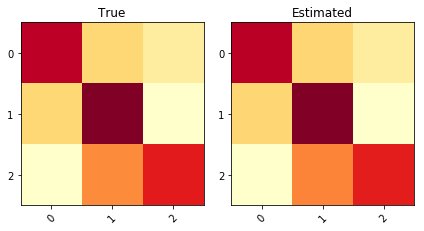

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


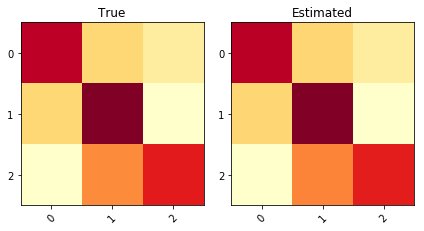

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


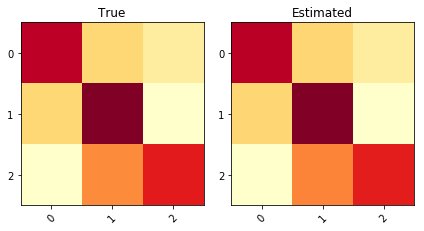

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


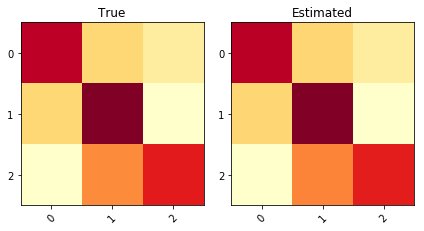

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


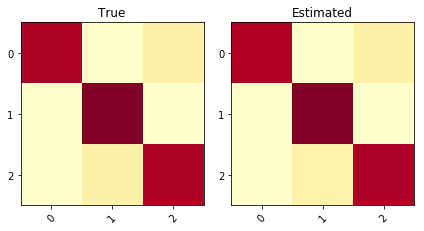

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


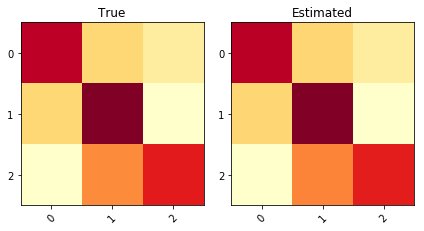

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


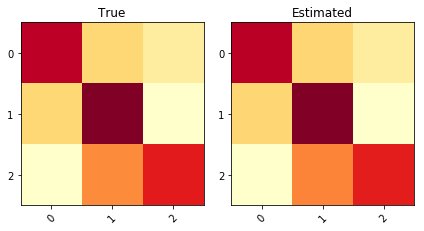

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


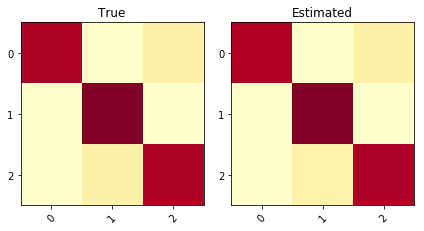

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


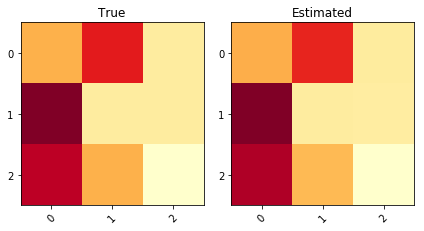

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


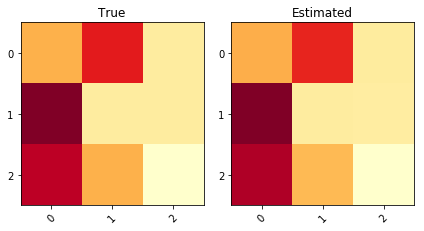

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


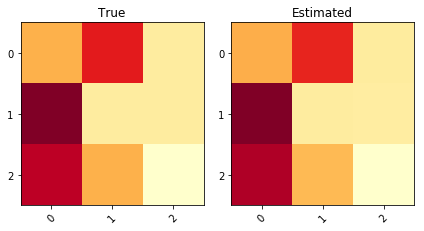

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


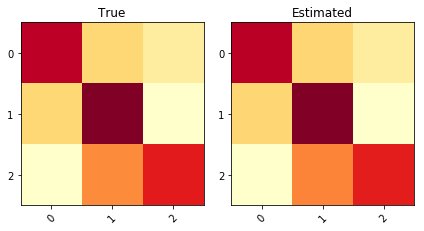

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


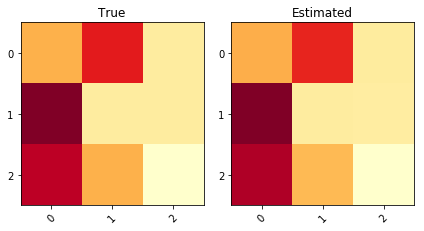

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


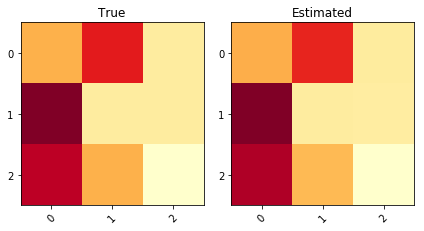

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


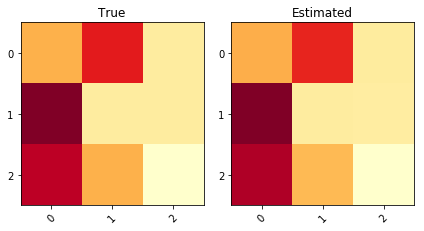

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


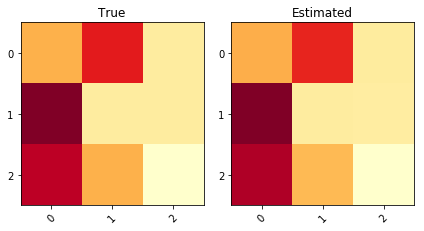

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


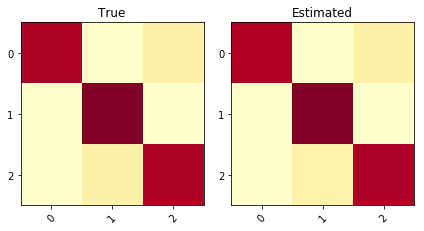

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


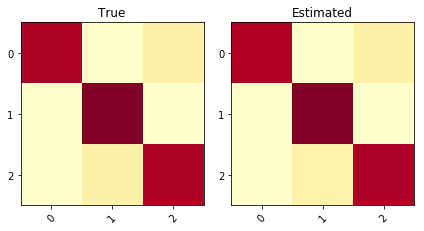

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


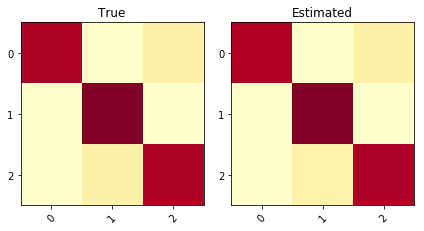

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


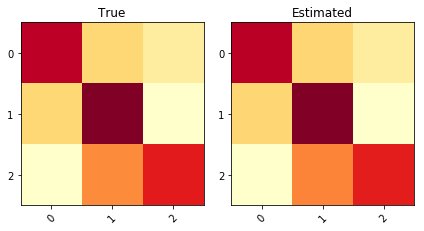

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


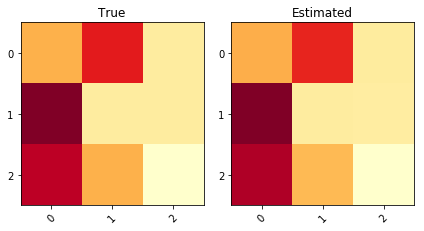

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


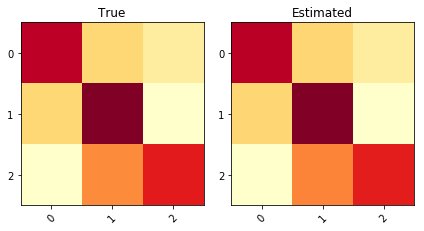

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


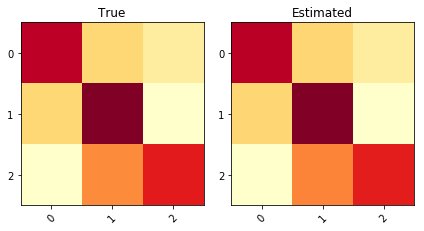

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


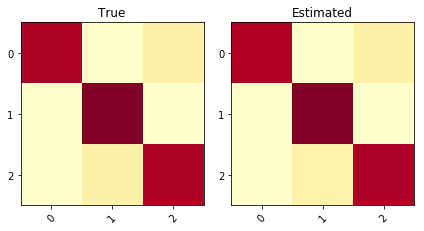

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


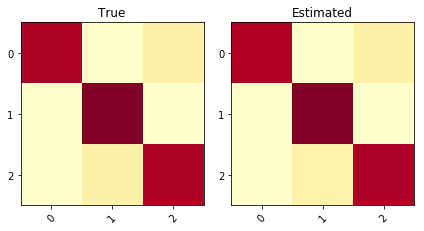

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


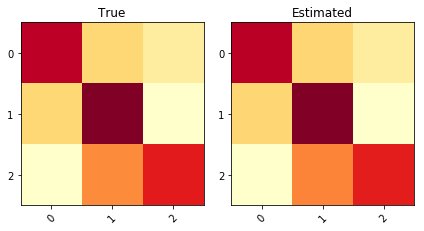

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


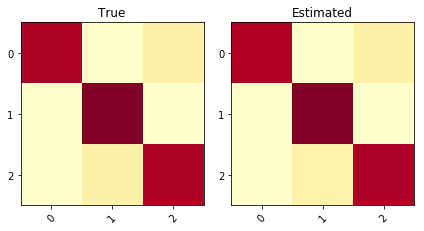

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


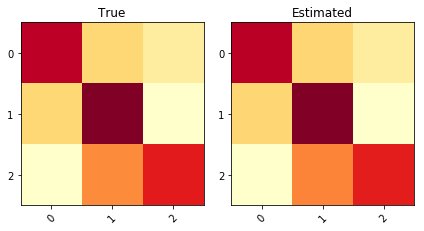

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


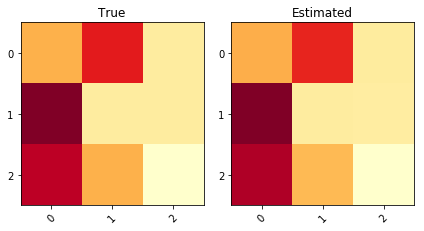

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


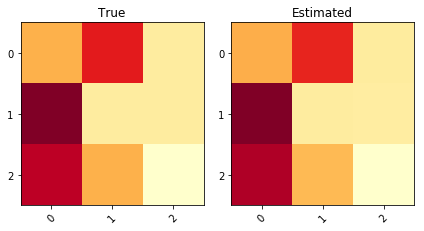

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


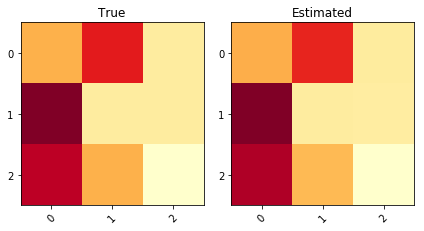

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


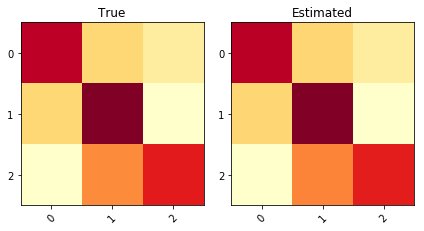

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


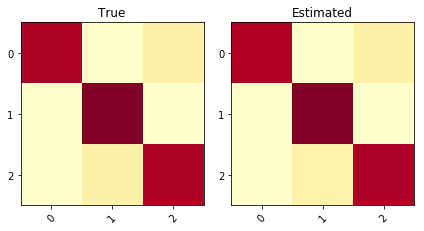

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


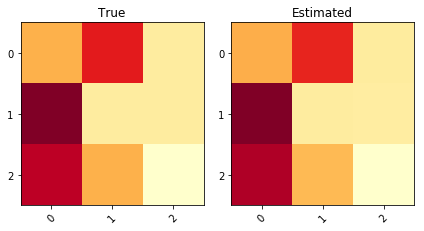

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


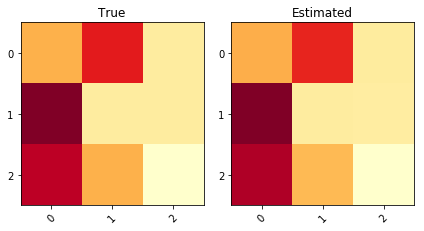

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


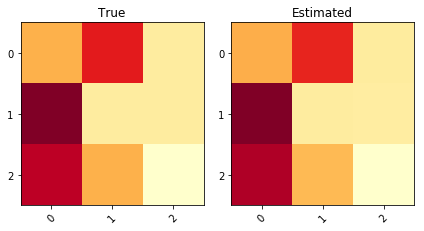

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


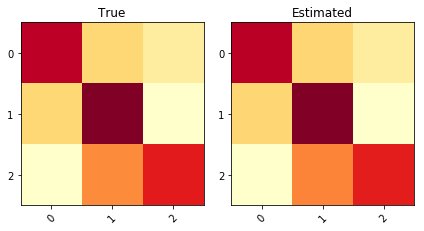

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


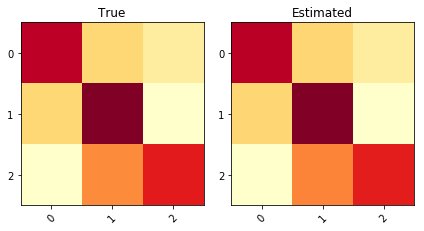

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


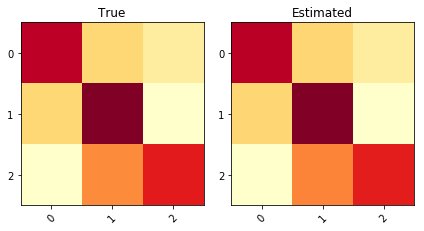

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


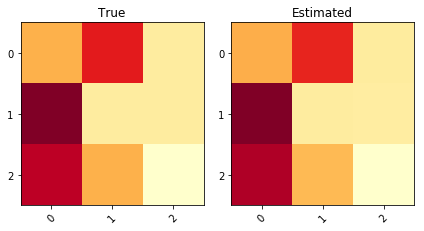

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


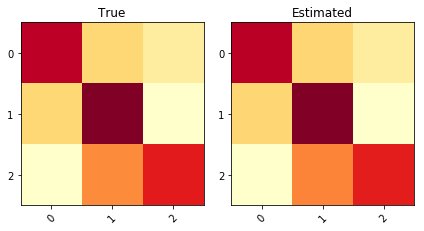

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


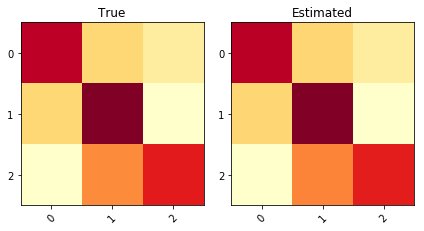

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


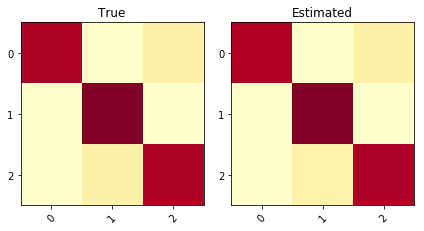

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


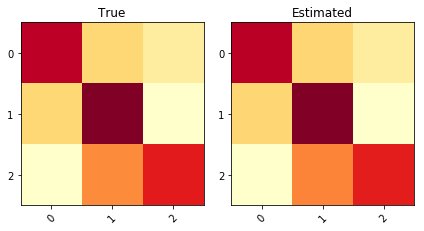

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


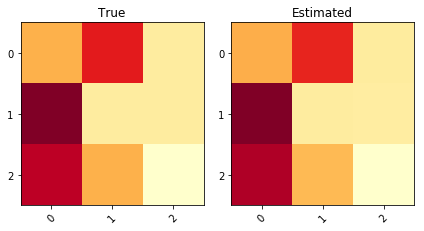

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


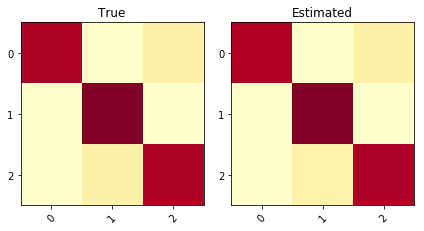

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


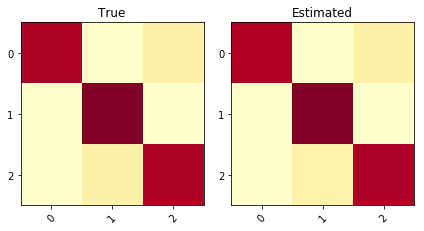

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


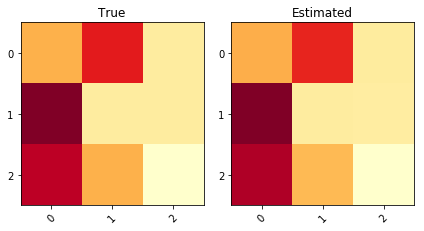

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


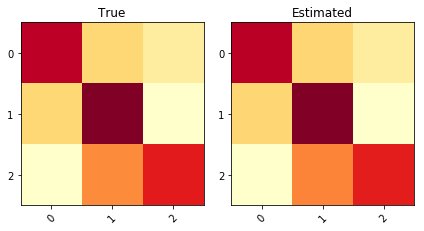

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


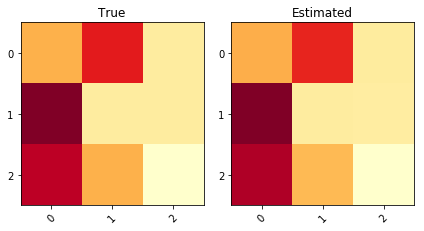

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


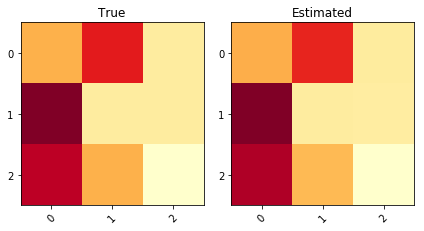

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


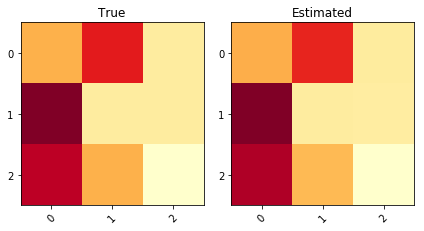

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


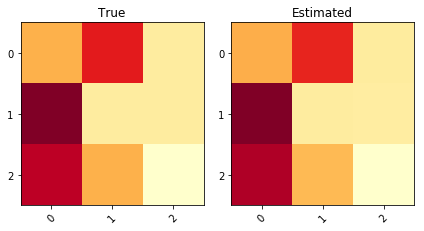

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


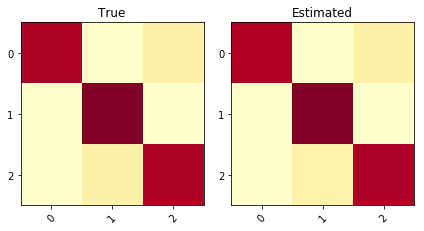

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


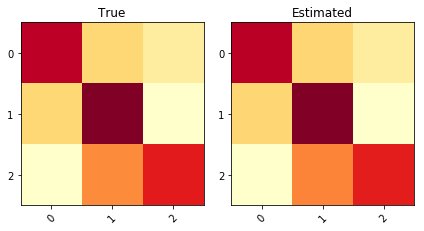

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


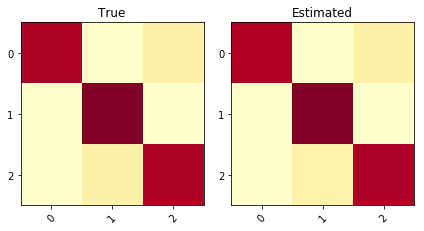

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


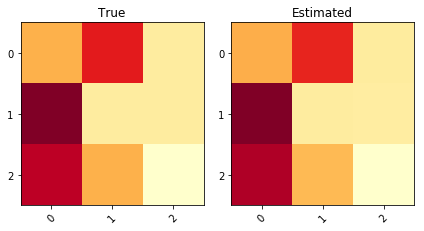

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


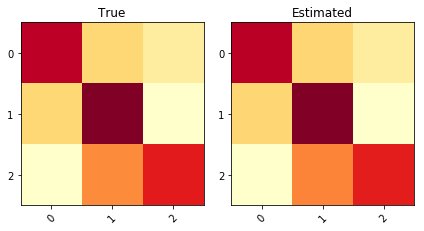

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


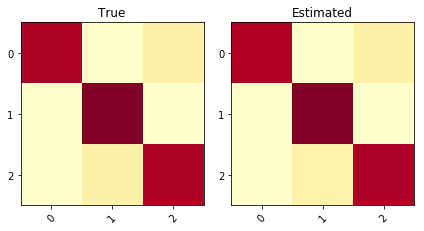

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


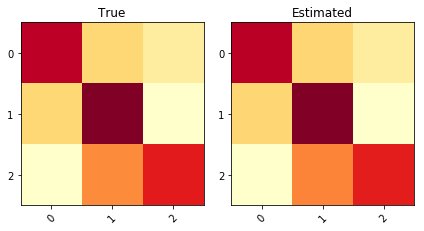

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


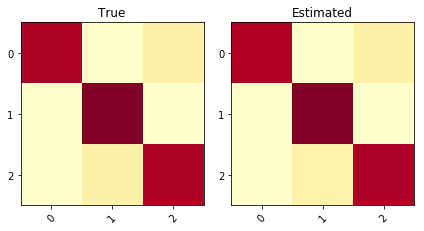

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


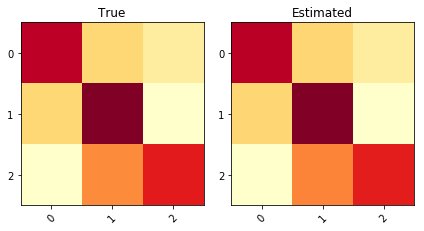

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


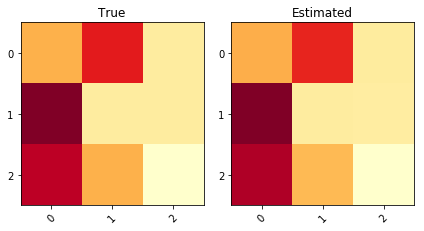

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


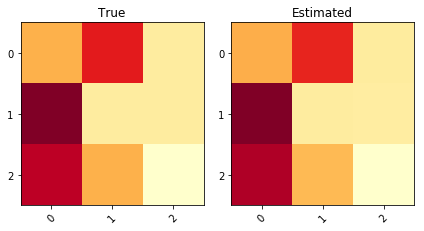

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


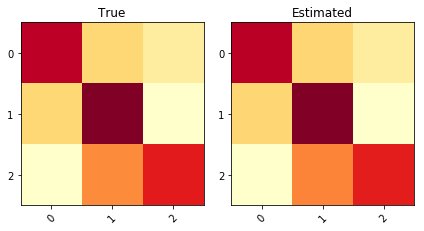

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


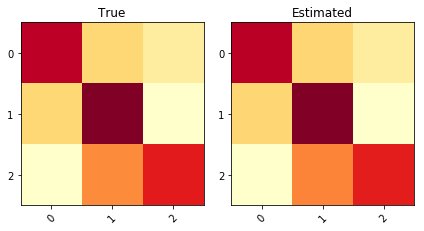

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


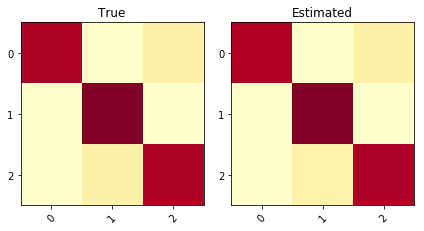

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


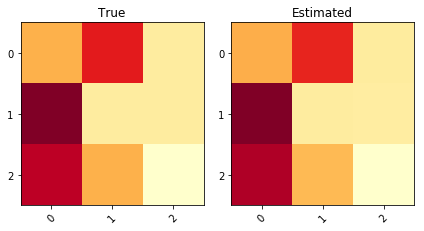

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


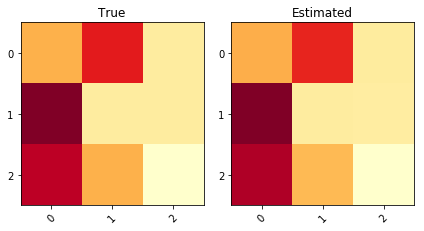

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


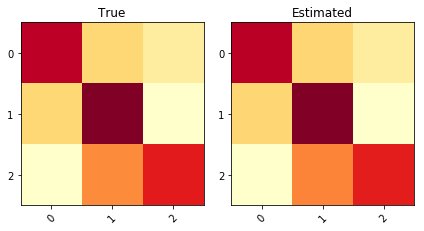

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


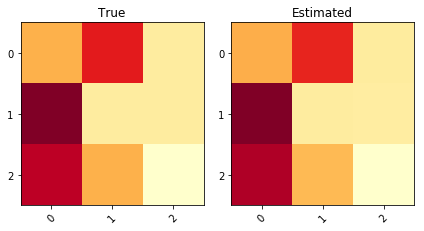

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


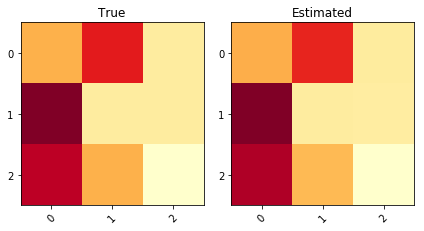

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


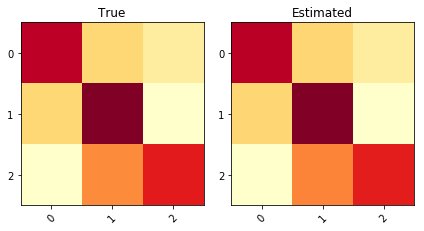

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


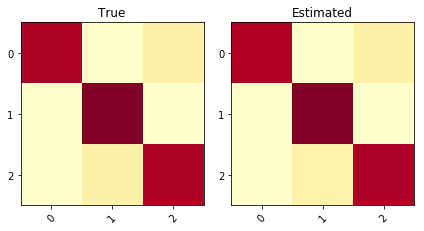

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


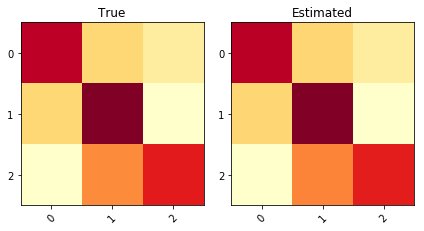

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


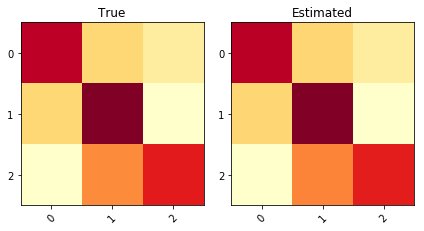

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


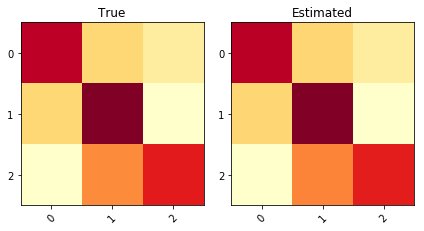

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


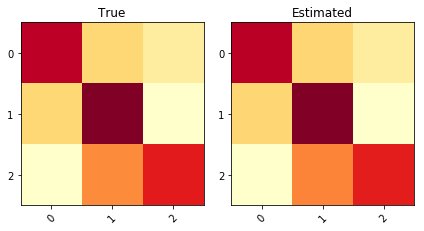

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


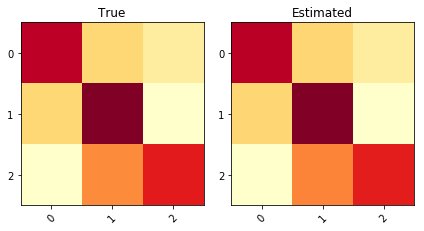

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


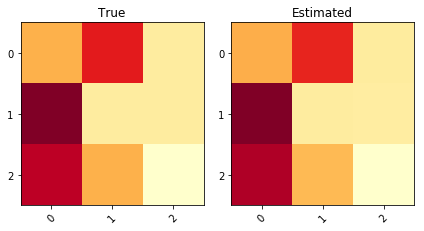

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


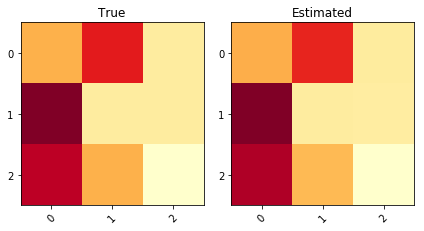

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


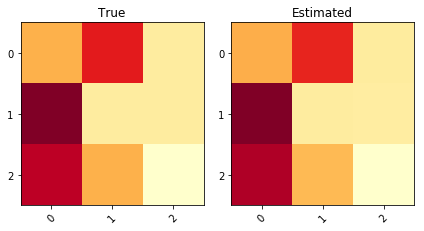

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


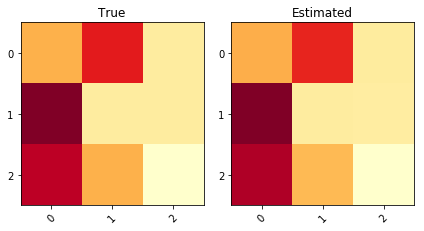

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


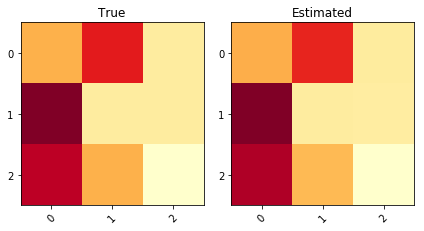

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


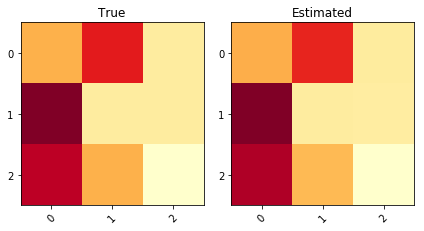

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


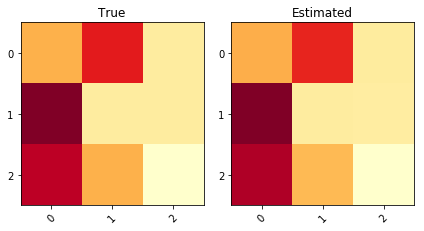

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


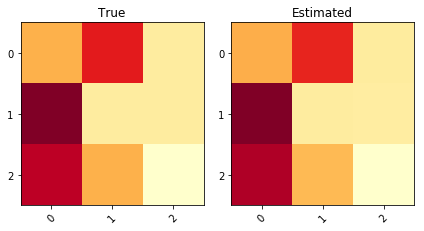

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


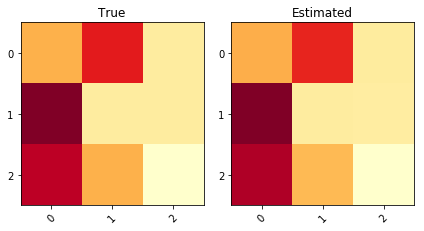

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


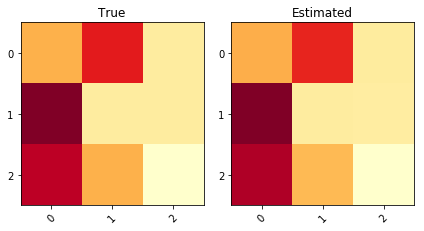

KL divergence:  0.001990312819418513
Entropy on estimated: 0.7285356871219685


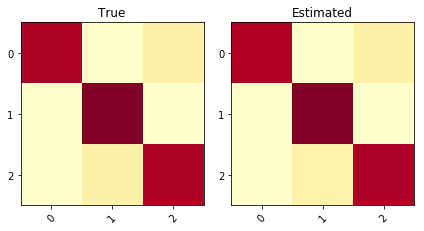

KL divergence:  0.0047785500155263436
Entropy on estimated: 0.2515865315773879


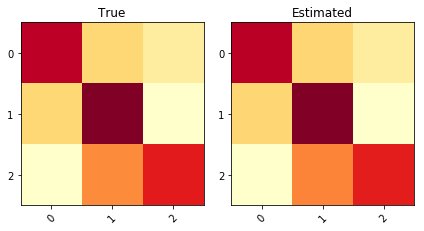

KL divergence:  0.002698397536711417
Entropy on estimated: 0.6823132959127509


Acccuracy,F1 score (micro),F1 score (macro),Average KL,Average Entropy
float64,float64,float64,float64,float64
0.9862962962962963,0.9862785455258257,0.9862962962962963,0.002830753128826603,0.6117363036222883


In [103]:
report_results(raykarMC.base_model.predict_classes(Xstd_test),Z_test,conf_pred=raykarMC.get_confusionM(),conf_true=annotators_conf)

In [47]:
raykarMC.get_qestimation()

array([[3.16173519e-38, 1.00000000e+00, 6.21480389e-22],
       [1.17651957e-24, 1.00000000e+00, 3.79586369e-15],
       [1.00000000e+00, 2.87964659e-36, 7.18144281e-22],
       ...,
       [4.90506683e-34, 1.00000000e+00, 4.65548812e-34],
       [3.68266835e-37, 1.00000000e+00, 1.05896644e-21],
       [1.06173849e-36, 8.48000618e-19, 1.00000000e+00]])

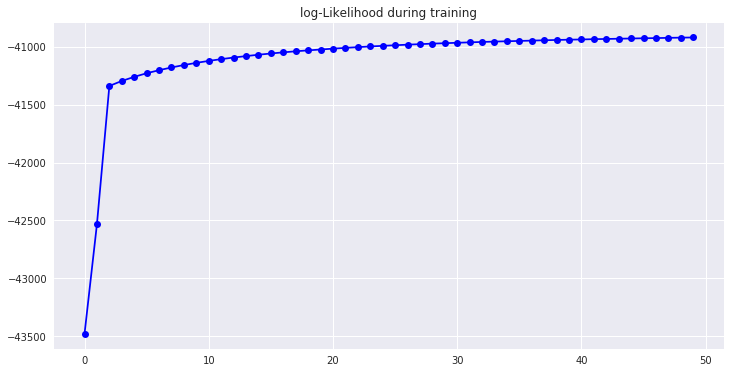

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(len(logL_hist)),logL_hist,'bo-')
plt.title("log-Likelihood during training")
plt.show()

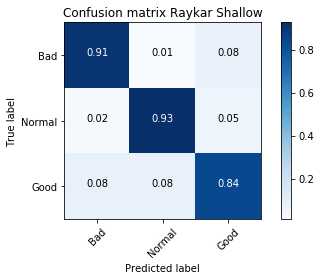

0.8908021074833226

In [116]:
from utils import *
classes = ["Bad","Normal","Good"]
plot_confusion_keras(raykarMC.get_basemodel(),Xstd_train,Z_train,classes,title='Confusion matrix Raykar Shallow')

calculate_f1_keras(raykarMC.get_basemodel(), Xstd_train, Z_train)

In [83]:
logL_iter = np.asarray([np.max(a) for a in logL_encontrado])
indexs_sort = np.argsort(logL_iter)[::-1] #mas grande primero
print("Indices: ",indexs_sort)
for ind in indexs_sort[:5]:
    print("F1 scores: %f y LogLoss %f "%(calculate_f1_keras(modelo_encontrado[ind], Xstd_train, Z_train),logL_iter[ind] ))

Indices:  [1 2 3 4 0]
F1 scores: 0.835033 y LogLoss -41122.005921 
F1 scores: 0.523017 y LogLoss -41378.791774 
F1 scores: 0.659264 y LogLoss -41390.114535 
F1 scores: 0.625109 y LogLoss -41422.275465 
F1 scores: 0.339236 y LogLoss -41579.881513 


> tambien se refleja que volver a ejecutar cambio los resultados (solo por la red)
* Mejor modelo aproxima un modelo con con mejor red (no necesariamente en orden el resto)...

### 4. Rodrigues 2013

In [ ]:
no

### 2. Melody Guan (2018)

### 3. Cluster (Kajino 2013)